## Import Packages

In [45]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objs as go
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from imblearn.combine import SMOTETomek 
from sklearn.model_selection import RandomizedSearchCV

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
#import gensim
#from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mnzy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mnzy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mnzy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load in data from kaggle.

In [46]:

train = pd.read_csv('train.csv')
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [47]:
test = pd.read_csv('test.csv')
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [48]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [49]:
# Cleaning the tweets
def clean_tweets(tweet):
    tweet = tweet.lower() #lowercase text
    tweet = tweet.strip()  #get rid of leading/trailing whitespace 
    tweet = re.compile('<.*?>').sub('', tweet) #Remove HTML tags/markups
    tweet = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', tweet)  #Replace punctuation with space.
    tweet = re.sub('\s+', ' ', tweet)  #Remove extra space and tabs
    tweet = re.sub(r'\[[0-9]*\]',' ',tweet) #[0-9] matches any digit (0 to 10000...)
    tweet =re.sub(r'[^\w\s]', '', str(tweet).lower().strip())
    tweet = re.sub(r'\d',' ',tweet) #matches any digit from 0 to 100000..., \D matches non-digits
    tweet = re.sub(r'\s+',' ',tweet) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    words = tweet.split()  

    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    return( " ".join(words))

#data = pd.read_csv('data/sample_data.csv')
train = train.dropna(subset=['message']) # remove any empty tweets

# cleaning the raw text data
train['message'] = train['message'].apply(clean_tweets)

# remove duplicates from data
train = train.drop_duplicates(subset=['message'])

In [50]:
tweet_distr = train.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False)
tweet_distr.style.background_gradient(cmap='Purples')

,sentiment,message
2,1,7219
3,2,3540
1,0,2237
0,-1,1221


In [51]:
fig = go.Figure(go.Funnelarea(text =tweet_distr.sentiment,values = tweet_distr.message,
title = {"position": "top center", "text": "Sentiment"}))
fig.show()

## Splitting out the X variable from the target

In [52]:
#Split our dataset

X = train['message']
y = train['sentiment']

## Splitting the training data into a training and validation set

In [53]:
#Splitting to training and velidation data

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,shuffle=True, stratify=y, random_state=46)

## Vectorization using TfidfVectorizer

In [54]:
# Logistic Regression
lrc_tfidf = Pipeline([('tfidf',TfidfVectorizer()),
               ('clf',LogisticRegression(C=1, 
                                         class_weight='balanced', 
                                         max_iter=1000))])


# K-NN Classifier
knnc_tfidf = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=5, 
                                             metric='minkowski', 
                                             p=2))])


# Linear SVC:
lsvc_tfidf = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(class_weight='balanced'))])


## Fitting the model to the classifier

In [55]:
# Logistic Regression
lrc_tfidf.fit(X_train, y_train)
y_pred_lr = lrc_tfidf.predict(X_val)

# K-NN Classifier
knnc_tfidf.fit(X_train, y_train)
y_pred_knn = knnc_tfidf.predict(X_val)

# Linear SVC
lsvc_tfidf.fit(X_train, y_train)
y_pred_lsvc = lsvc_tfidf.predict(X_val)

              precision    recall  f1-score   support

          -1       0.52      0.61      0.56       244
           0       0.49      0.54      0.51       448
           1       0.83      0.63      0.72      1444
           2       0.64      0.87      0.74       708

    accuracy                           0.67      2844
   macro avg       0.62      0.66      0.63      2844
weighted avg       0.70      0.67      0.68      2844



Text(0.5, 1.0, 'Logistic Regression Classifire')

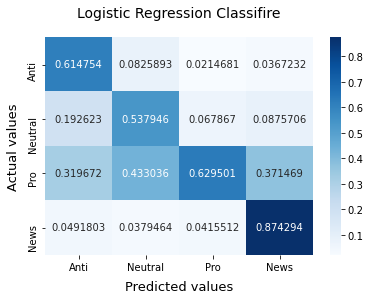

In [56]:
#
print(classification_report(y_val, y_pred_lr))

cf_matrix = confusion_matrix(y_val, y_pred_lr)
cf_matrix = cf_matrix/cf_matrix.astype(np.float).sum(axis=1)

categories = ['Anti','Neutral','Pro','News']
df_cf_matrix = pd.DataFrame(cf_matrix, index = categories, columns = categories)
sns.heatmap(df_cf_matrix, annot=True,cmap='Blues', fmt='g')
plt.xlabel("Predicted values", fontdict = {'size':13}, labelpad = 8)
plt.ylabel("Actual values" , fontdict = {'size':13}, labelpad = 8)
plt.title ("Logistic Regression Classifire", fontdict = {'size':14}, pad = 20)

              precision    recall  f1-score   support

          -1       0.46      0.35      0.40       244
           0       0.39      0.33      0.36       448
           1       0.67      0.75      0.71      1444
           2       0.67      0.62      0.64       708

    accuracy                           0.62      2844
   macro avg       0.55      0.51      0.53      2844
weighted avg       0.61      0.62      0.61      2844



<AxesSubplot:>

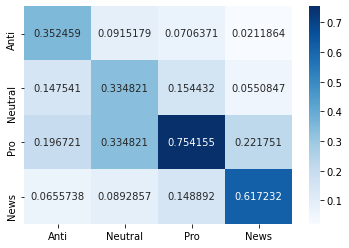

In [57]:
print(classification_report(y_val, y_pred_knn))

cf_matrix = confusion_matrix(y_val, y_pred_knn)
cf_matrix = cf_matrix/cf_matrix.astype(np.float).sum(axis=1)

categories = ['Anti','Neutral','Pro','News']
df_cf_matrix = pd.DataFrame(cf_matrix, index = categories, columns = categories)
sns.heatmap(df_cf_matrix, annot=True,cmap='Blues', fmt='g')

              precision    recall  f1-score   support

          -1       0.61      0.57      0.58       244
           0       0.53      0.47      0.49       448
           1       0.79      0.75      0.77      1444
           2       0.69      0.82      0.75       708

    accuracy                           0.71      2844
   macro avg       0.65      0.65      0.65      2844
weighted avg       0.71      0.71      0.70      2844



<AxesSubplot:>

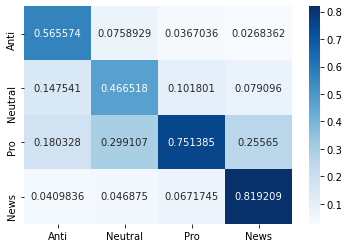

In [58]:
print(classification_report(y_val, y_pred_lsvc))

cf_matrix = confusion_matrix(y_val, y_pred_lsvc)
cf_matrix = cf_matrix/cf_matrix.astype(np.float).sum(axis=1)

categories = ['Anti','Neutral','Pro','News']
df_cf_matrix = pd.DataFrame(cf_matrix, index = categories, columns = categories)
sns.heatmap(df_cf_matrix, annot=True,cmap='Blues', fmt='g')

## F1- scores of basic models

In [59]:
# F1-Score test for Logistic Regression Classifier
f1_score(y_val, y_pred_lr, average="macro")

0.6330868510961072

In [60]:
# F1-Score test for K-NN Classifier Classifier
f1_score(y_val,y_pred_knn , average="macro")

0.5287945547656253

In [61]:
# F1-Score test for Linear SVC Classifier
f1_score(y_val, y_pred_lsvc, average="macro")

0.6495001786558574

## Hyper Parameter Tuning

In [62]:
# Set ranges for the parameters to tune 
parameters = {'clf__C': [0.1, 0.2, 0.3, 0.4, 0.5],
          'tfidf__ngram_range' : [(1,1),(1,2)],
          'clf__max_iter': [1500, 2000, 2500, 3000],
          'tfidf__min_df': [2, 3, 4],
          'tfidf__max_df': [0.8, 0.9]}

#Estimator
clf_ = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(class_weight='balanced'))])

# Perform randomised search & extract the optimal parameters
Randomized = RandomizedSearchCV(clf_,param_distributions=parameters, cv=5, scoring='accuracy', n_iter=5, random_state=42)
Randomized.fit(X_train,y_train)
Randomized.best_estimator_


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=(1, 2))),
                ('clf',
                 LinearSVC(C=0.3, class_weight='balanced', max_iter=2000))])

## Fitting optimised model 

In [63]:
 # Optimised Linear SVC
lsvc_opt_model = Pipeline([('tfidf', TfidfVectorizer(max_df = 0.8, min_df=2, ngram_range=(1,2))),
                 ('clf', LinearSVC(C=0.3, class_weight='balanced', max_iter=2000))])


# Fit the optimised Linear SVC
lsvc_opt_model.fit(X_train, y_train)
y_pred = lsvc_opt_model.predict(X_val)

## F1- score of optimised model

In [64]:
# F1-Score test for optimised Linear SVC Classifier
f1_score(y_val,  y_pred, average="macro")

0.6709170282749684

## Making predictions on the test set

In [ ]:
df_test = pd.read_csv('../input/edsa-climate-change-belief-analysis-2021/test.csv')
y_test = lsvc_basic_model.predict(df_test['message'])
output = pd.DataFrame({'tweetid': df_test.tweetid,
                       #'sentiment': y_test})
output.to_csv('submission.csv', index=False) 

output 